In [1]:
import os
import pandas as pd
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from keras import models, optimizers
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
# Global parameters
image_height = 150
image_width = 150
channels = 3
batch_size = 64
epochs = 50

#### Define model

In [3]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (4, 4), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

rmsprop = optimizers.RMSprop(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)      

**Format data into appropriate floating point tensors**
* Read the picture files
* Decode the JPEG content to RGB grids of pixels
* Convert these into floating point tensors
* Rescale the pixel values (between 0 and 255) to the [0,1] interval (neural networks prefer to deal with small input values)

#### Read data
The dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

In [4]:
PATH = '/Users/fi000980702/Documents/Work/Chapter5/data/'
train_dir = os.path.join(PATH, 'training')
val_dir = os.path.join(PATH, 'validation')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [6]:
num_cats_train = len(os.listdir(train_cats_dir))
num_dogs_train = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(val_cats_dir))
num_dogs_val = len(os.listdir(val_dogs_dir))

total_train = num_cats_train + num_dogs_train
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_train)
print('total training dog images:', num_dogs_train)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 4000
total training dog images: 4000
total validation cat images: 1000
total validation dog images: 1000
--
Total training images: 8000
Total validation images: 2000


##### Preprocess data

In [8]:
# Set up augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.4, 
    horizontal_flip=True,
    fill_mode='nearest') 

# Validation data will not augmented
val_datagen = ImageDataGenerator(rescale=1./255) 

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True,                                         # Shuffle the training data but not the validation data
    class_mode='binary')        

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
for data_batch, label_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('label batch shape', label_batch.shape)
    break;  

data batch shape (64, 150, 150, 3)
label batch shape (64,)


* Sample of augmentated images

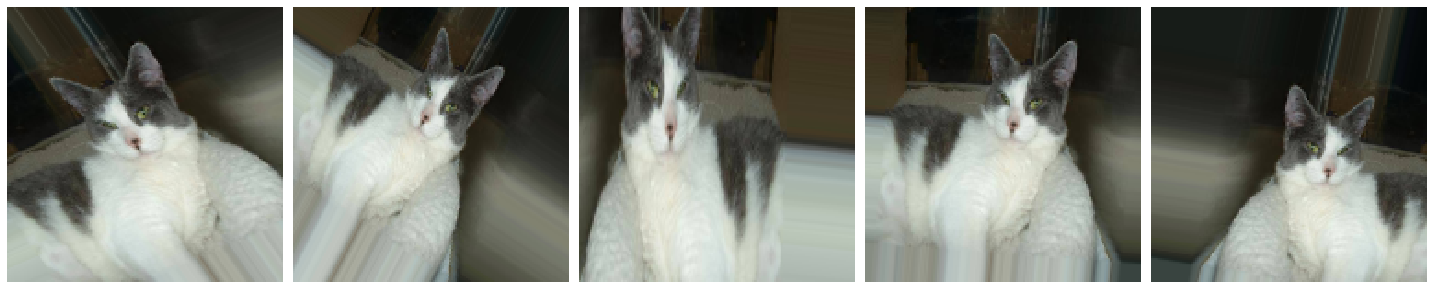

In [11]:
augmented_images = [train_generator[0][0][0] for _ in range(5)]
fig, ax = plt.subplots(1, 5, figsize=(20,20))
ax = ax.flatten()

for img, ax in zip(augmented_images, ax):
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

##### Train the model

In [12]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=total_train // batch_size, 
    epochs=epochs,
    validation_data=val_generator, 
    validation_steps=total_val // batch_size)
 
total_time = (time.time() - start_time)/60                                     
print('Execution time {:2f} minutes'.format(total_time))       

Epoch 1/50
125/125 [==============================] - 510s 4s/step - loss: 0.6948 - acc: 0.5107 - val_loss: 0.7020 - val_acc: 0.5005
Epoch 2/50
125/125 [==============================] - 534s 4s/step - loss: 0.6848 - acc: 0.5433 - val_loss: 0.6645 - val_acc: 0.5863
Epoch 3/50
125/125 [==============================] - 356s 3s/step - loss: 0.6764 - acc: 0.5700 - val_loss: 0.7048 - val_acc: 0.5465
Epoch 4/50
125/125 [==============================] - 298s 2s/step - loss: 0.6706 - acc: 0.5863 - val_loss: 0.7456 - val_acc: 0.5568
Epoch 5/50
125/125 [==============================] - 299s 2s/step - loss: 0.6592 - acc: 0.6047 - val_loss: 0.6882 - val_acc: 0.5584
Epoch 6/50
125/125 [==============================] - 299s 2s/step - loss: 0.6543 - acc: 0.6085 - val_loss: 0.6439 - val_acc: 0.6250
Epoch 7/50
125/125 [==============================] - 299s 2s/step - loss: 0.6468 - acc: 0.6271 - val_loss: 0.7171 - val_acc: 0.6291
Epoch 8/50
125/125 [==============================] - 296s 2s/step - 

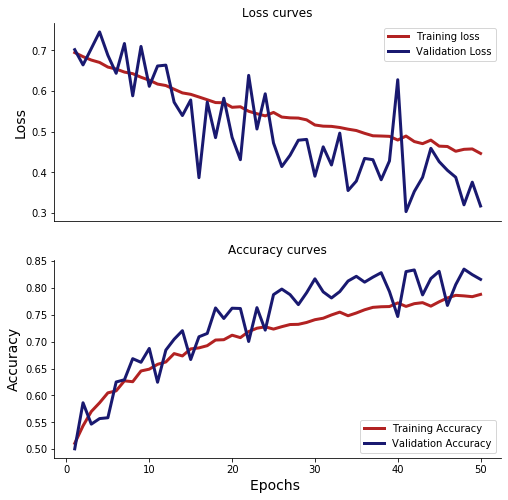

In [15]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,8))

history_dict = history.history
epochs = range(1, len(history_dict['acc'])+1)

ax0.plot(epochs, history_dict['loss'], 'firebrick', linewidth=3.0)
ax0.plot(epochs, history_dict['val_loss'], 'midnightblue', linewidth=3.0)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.tick_params(bottom=False)
ax0.set_xticklabels([])
ax0.set_title('Loss curves')
ax0.set_ylabel('Loss', fontsize=14)
ax0.legend(['Training loss', 'Validation Loss'], loc='best')

ax1.plot(epochs, history_dict['acc'], 'firebrick', linewidth=3.0)
ax1.plot(epochs, history_dict['val_acc'], 'midnightblue' ,linewidth=3.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Accuracy curves')
ax1.set_xlabel('Epochs ', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14)
ax1.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')